# Clustered Summary

This is an attempt to implement the idea of [How to Summarize Large Documents with LangChain and OpenAI](https://medium.com/@myscale/how-to-summarize-large-documents-with-langchain-and-openai-4312568e80b1) in dotnet with Amazon Bedrock.

## Parsing

For PDF parsing we use [PdfPig](https://github.com/UglyToad/PdfPig). See the [NOTICE](NOTICE) file for license information.

In [1]:
#r "nuget: PdfPig"

Installed Packages PdfPig, 0.1.10

In [2]:
using System.IO;
using UglyToad.PdfPig;

string GetText(FileInfo file)
{
    var text = new StringBuilder();

    using (var pdfDocument = PdfDocument.Open(file.FullName))
    {
        foreach (var page in pdfDocument.GetPages())
        {
            // word grouping by bottom coordinates taken from https://stackoverflow.com/a/75043692/6466378
            var wordsList = page.GetWords().GroupBy(x => x.BoundingBox.Bottom);
            foreach (var word in wordsList)
            {
                foreach (var item in word)
                {
                    text.Append(item.Text + " ");
                }
                text.Append("\n");
            }
        }
    }
    return text.ToString();
}

In [3]:
var file = new FileInfo("documents\\Towards Trust in Legal AI - Enhancing LLMs with Retrieval Augmented Generation.pdf");
var text = GetText(file);
display($"{text.Length} characters");

299821 characters

## Partitioning

For text paritioning/chunking we use [SemanticKernel](https://github.com/microsoft/semantic-kernel).

In [4]:
#r "nuget: Microsoft.SemanticKernel.Core"

Installed Packages Microsoft.SemanticKernel.Core, 1.46.0

In [5]:
using Microsoft.SemanticKernel.Text;

string[] Partition(string text) 
{
    //Currently we use static chunking. We should replace this with semantic chunking in the future.
    const int maxTokensPerLine = 200;
    const int maxTokensPerParagraph = 700;
    const int overlappingTokens = 70;
    const double charactersPerToken = 4.7; //https://docs.aws.amazon.com/bedrock/latest/userguide/titan-embedding-models.html

    #pragma warning disable SKEXP0050 // experminental API
    TextChunker.TokenCounter tokenCounter = (string s) => (int)(s.Length / charactersPerToken);
    var sentences = TextChunker.SplitPlainTextLines(text, maxTokensPerLine: maxTokensPerLine, tokenCounter: tokenCounter);
    var partitions = TextChunker.SplitPlainTextParagraphs(sentences, maxTokensPerParagraph: maxTokensPerParagraph, overlapTokens: overlappingTokens, tokenCounter: tokenCounter, chunkHeader: null);
    #pragma warning restore SKEXP0050 // experminental API

    return partitions.ToArray();
}

In [6]:
var partitions = Partition(text);
display($"{partitions.Length} partitions");

107 partitions

## Embedding

For text embedding we use [Amazon Titan Text Embeddings v2](https://docs.aws.amazon.com/bedrock/latest/userguide/titan-embedding-models.html) on Amazon Bedrock.

In [7]:
#r "nuget: AWSSDK.BedrockRuntime"
#r "nuget: Microsoft.Extensions.Configuration.Json"

Installed Packages AWSSDK.BedrockRuntime, 3.7.418.3 Microsoft.Extensions.Configuration.Json, 9.0.4

In [8]:
using Amazon.BedrockRuntime;
using Amazon.BedrockRuntime.Model;
using Microsoft.Extensions.Configuration;

var config = new ConfigurationBuilder()
    .SetBasePath(Directory.GetCurrentDirectory())
    .AddJsonFile("appsettings.json", optional: false)
	.AddJsonFile("appsettings.local.json", optional: true)
    .Build();

var bedrock = new AmazonBedrockRuntimeClient(
	awsAccessKeyId: config["AWSBedrockAccessKeyId"]!,
	awsSecretAccessKey: config["AWSBedrockSecretAccessKey"]!,
	region: Amazon.RegionEndpoint.GetBySystemName(config["AWSBedrockRegion"]!));

In [9]:
using System.Text.Json;
using System.Threading;
using Amazon.Util;

record EmbeddingRequest(string inputText);
record EmbeddingResponse(float[] embedding, int inputTextTokenCount);

async Task<EmbeddingResponse> Embed(string text, CancellationToken cancellationToken = default)
{
    var requestBody = AWSSDKUtils.GenerateMemoryStreamFromString(JsonSerializer.Serialize(new EmbeddingRequest(text)));
    var request = new InvokeModelRequest
    {
        ModelId = "amazon.titan-embed-text-v2:0",
        Body = requestBody,
    };
    var response = await bedrock.InvokeModelAsync(request, cancellationToken);
    var embedded = await JsonSerializer.DeserializeAsync<EmbeddingResponse>(response.Body, cancellationToken: cancellationToken);
    return embedded;
}

We embed all partitions in parallel.

In [10]:
using System.Linq;
using System.Diagnostics;

record Embedding(float[] embedding, int inputTokens, int paritionIndex);

var embeddingStopwatch = Stopwatch.StartNew();
var embeddingTasks = partitions
    .Select((p, i) => (value: p, index: i))
    .Select(async partition =>
    {
        var embedding = await Embed(partition.value);
        return new Embedding(embedding.embedding, embedding.inputTextTokenCount, partition.index);
    })
    .ToList();
await Task.WhenAll(embeddingTasks);
var embeddings = embeddingTasks.Select(t => t.Result).ToList();
var totalInputTokens = embeddings.Sum(s => s.inputTokens);
embeddingStopwatch.Stop();

display($"Parallel embedding {embeddings.Count} times took {embeddingStopwatch.Elapsed} and {totalInputTokens} input tokens");

Parallel embedding 107 times took 00:00:00.8039013 and 73674 input tokens

## Clustering

For clustering we use K-means with [ML.NET](https://dotnet.microsoft.com/en-us/apps/ai/ml-dotnet).

In [11]:
#r "nuget: Microsoft.ML"

Installed Packages Microsoft.ML, 4.0.2

In [12]:
using Microsoft.ML;
using Microsoft.ML.Data;
using Microsoft.ML.Trainers;

record DataPoint([property:KeyType(2)] uint PartitionIndex, [property:VectorType(1024)] float[] Features);
record Cluster(uint ClusterId, float[] Centroid, DataPoint[] DataPoints);

List<Cluster> Kmeans(IEnumerable<DataPoint> dataPoints, int k = 10)
{
    var mlContext = new MLContext(seed: 0);
    
    //Load
    var dataView = mlContext.Data.LoadFromEnumerable(dataPoints);
    
    //Normalize (Does it really make a difference? If we need to, we need to normalize the embeddings in general, not only for clustering.)
    // var dataProcessingPipeline = mlContext.Transforms.NormalizeMeanVariance(nameof(DataPoint.Features));
    // var processedData = dataProcessingPipeline.Fit(dataView).Transform(dataView);
    var processedData = dataView;
    
    //Train
    var pipeline = mlContext.Clustering.Trainers.KMeans(new KMeansTrainer.Options
    {
        NumberOfClusters = k,
        FeatureColumnName = nameof(DataPoint.Features),
    });
    var model = pipeline.Fit(processedData);
    
    //Get cluster centroids
    VBuffer<float>[] centroids = default;
    var modelParams = model.Model;
    modelParams.GetClusterCentroids(ref centroids, out int clusters);

    //Get cluster assignments
    var transformed = model.Transform(processedData);
    var clusterAssignments = transformed.GetColumn<uint>("PredictedLabel").ToList();

    return dataPoints
        .Zip(clusterAssignments, (dataPoint, clusterId) => (clusterId, dataPoint))
        .GroupBy(x => x.clusterId, x => x.dataPoint)
        .Select(g => new Cluster(g.Key, centroids[g.Key-1/*we assume clusterId correlates with centroidIndex*/].DenseValues().ToArray(), g.ToArray()))
        .OrderByDescending(c => c.DataPoints.Length)
        .ToList();
}

In [13]:
var kmeansStopwatch = Stopwatch.StartNew();
var dataPoints = embeddings.Select(e => new DataPoint((uint)e.paritionIndex, e.embedding));
var clusters = Kmeans(dataPoints);
var clusterCenters = clusters.Select(c => c.Centroid).ToList();
kmeansStopwatch.Stop();
display($"K-means took {kmeansStopwatch.Elapsed} to build {clusterCenters.Count} clusters");

K-means took 00:00:00.1148899 to build 10 clusters

## Visualizing

For visualizing vectors we use [ScottPlot](https://scottplot.net/).

In [14]:
#r "nuget: ScottPlot"

Installed Packages ScottPlot, 5.0.55

Loading extensions from `C:\Users\manue\.nuget\packages\skiasharp\2.88.9\interactive-extensions\dotnet\SkiaSharp.DotNet.Interactive.dll`

In [15]:
using Microsoft.DotNet.Interactive.Formatting;

Formatter.Register(typeof(ScottPlot.Plot), (p, w) => w.Write(((ScottPlot.Plot)p).GetPngHtml(800, 600)), HtmlFormatter.MimeType);

Principal Component Analysis (PCA) to reduce the 1024 dimensions of semantic vectors to two new dimensions that represent the most impactful dimensions. This transformation is lossy, so we expect clusters not overlap a little. That is ok, because we only use PCA to visualize our vectors in 2 dimensional space. All decisions are made in 1024 dimensional space.

In [16]:
using Microsoft.ML.Transforms;

record VectorWithPC([property:KeyType(2)] uint PartitionIndex, [property:VectorType(1024)] float[] Vector, [property:VectorType(2)] float[] PrincipalComponents);

List<VectorWithPC> Pca(IEnumerable<DataPoint> dataPoints, int rank = 2)
{
    var mlContext = new MLContext(seed: 0);
    
    //Load
    var dataView = mlContext.Data.LoadFromEnumerable(dataPoints);
    
    //Train
    var pca = mlContext.Transforms.ProjectToPrincipalComponents(nameof(DataPoint.Features), rank: rank, seed: 1);
    var model = pca.Fit(dataView);
    
    //Get principal components
    var transformed = model.Transform(dataView);
    var principalComponents = transformed.GetColumn<float[]>(nameof(DataPoint.Features)).ToList();

    return dataPoints.Zip(principalComponents, (d, pc) => new VectorWithPC(d.PartitionIndex, d.Features, pc)).ToList();
}

In [17]:
var principalComponents = Pca(dataPoints, rank: 2);
display(principalComponents);

index value 0 VectorWithPC { PartitionIndex = 0, Vector = System.Single[], PrincipalComponents = System.Single[] } PartitionIndex 0 Vector [ -0.022368683, 0.008402194, 0.017856564, 0.019630658, -0.012261558, 0.04566205, 0.003324321, -0.051679354, -0.03585515, -0.046184435, 0.023875214, 0.0061313817, 0.046334457, 0.023555033, -0.029963683, -0.02095379, -0.05458847, -0.031777926, 0.05641833, -0.009130555 ... (1004 more) ] PrincipalComponents [ -0.0019570217, -0.37094945 ] 1 VectorWithPC { PartitionIndex = 1, Vector = System.Single[], PrincipalComponents = System.Single[] } PartitionIndex 1 Vector [ 0.00091845944, 0.014315809, -0.0016524466, 0.042475842, -0.022037318, -0.00015973226, -0.0047988463, -0.047916334, -0.008189437, -0.049312163, 0.06940773, 0.04106665, 0.01918682, 0.0029068391, -0.01290314, -0.04814195, -0.021349372, -0.018703694, 0.047314283, -0.017007232 ... (1004 more) ] PrincipalComponents [ 0.19562557, 0.019216664 ] 2 VectorWithPC { PartitionIndex = 2, Vector = System.Single[], PrincipalComponents = System.Single[] } PartitionIndex 2 Vector [ 0.006071999, -0.025151715, 0.0500454, 0.01047808, 0.010324988, -0.044398014, 0.013335204, -0.045829225, 0.009758239, 0.00037875577, 0.0442665, 0.031743847, 0.01864334, 0.01737153, -0.0113384025, -0.02167322, -0.049411718, -0.038668115, 0.0409865, 0.014520646 ... (1004 more) ] PrincipalComponents [ 0.24687394, 0.23066668 ] 3 VectorWithPC { PartitionIndex = 3, Vector = System.Single[], PrincipalComponents = System.Single[] } PartitionIndex 3 Vector [ 0.017737957, 0.08992474, 0.005166321, 0.028934216, 0.0013158566, 0.02323, 0.030137446, -0.03072682, -0.057460684, -0.017580267, 0.0010720231, 0.021552458, 0.067205116, 0.0636632, -0.059127536, -0.034628257, -0.037037436, 0.013829009, 0.037078407, 0.04018394 ... (1004 more) ] PrincipalComponents [ -0.17831081, -0.10229066 ] 4 VectorWithPC { PartitionIndex = 4, Vector = System.Single[], PrincipalComponents = System.Single[] } PartitionIndex 4 Vector [ -0.019503282, -0.004036641, 0.033176214, 0.046210438, -0.050666258, 0.0093920855, 0.0269893, -0.04447292, -0.02813685, -0.021393886, 0.041291516, 0.02477247, 0.03882626, 0.036468726, -0.030232957, -0.043144424, -0.05528761, -0.037075866, 0.065126725, 0.0060371626 ... (1004 more) ] PrincipalComponents [ 0.1368073, -0.1975478 ] 5 VectorWithPC { PartitionIndex = 5, Vector = System.Single[], PrincipalComponents = System.Single[] } PartitionIndex 5 Vector [ -0.027712213, 0.037135113, 0.036642503, 0.030476384, 0.0005554022, 0.0062002484, 0.017087765, -0.066819996, 0.00301993, -0.0062265564, 0.08468849, 0.027603528, 0.027402585, 0.0030736716, -0.027880257, 0.047534633, -0.018861748, -0.008353293, -0.052448496, 0.039006755 ... (1004 more) ] PrincipalComponents [ 0.1396248, 0.22581907 ] 6 VectorWithPC { PartitionIndex = 6, Vector = System.Single[], PrincipalComponents = System.Single[] } PartitionIndex 6 Vector [ -0.00631671, 0.020037955, -0.035363533, 0.052150052, -0.0018198133, 0.020621698, -0.02048302, -0.032367554, -0.0043567447, -0.052028153, 0.042890355, 0.021848723, 0.00820276, 0.056926593, -0.006207172, 0.0143969385, -0.08648104, -0.0076645426, -0.019704496, 0.06860766 ... (1004 more) ] PrincipalComponents [ -0.09222023, 0.1628741 ] 7 VectorWithPC { PartitionIndex = 7, Vector = System.Single[], PrincipalComponents = System.Single[] } PartitionIndex 7 Vector [ -0.016581912, 0.019809248, 0.037546337, 0.064738095, -0.023518125, 0.0035330562, 0.029944276, -0.060096737, -0.019259539, -0.028557228, 0.057891466, 0.053344548, 0.070079125, 0.044812582, -0.039759845, -0.014632102, 0.006053088, -0.020048067, 0.02873111, 0.031433176 ... (1004 more) ] PrincipalComponents [ -0.06414528, 0.19697273 ] 8 VectorWithPC { PartitionIndex = 8, Vector = System.Single[], PrincipalComponents = System.Single[] } PartitionIndex 8 Vector [ -0.05797046, -0.029952737, 0.023983961, 0.013613868, -0.037187483, -0.019795544, 0.035697337, -0.06673983, 0.03277731, -0.038300797, 0.04084699, -0.017960208, 0.0020672877, 0.010


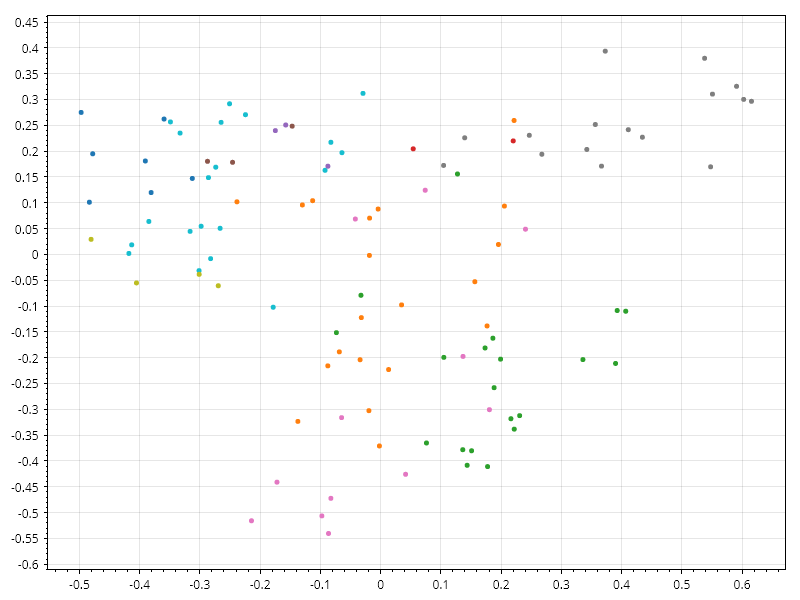

In [18]:
var colorPalette = new ScottPlot.Palettes.Category10();
var colors = colorPalette.Colors.ToArray();

ScottPlot.Plot allDataPointsPlot = new();
foreach (var cluster in clusters)
{
    var color = colors.ElementAt((int)cluster.ClusterId % colors.Length);
    foreach (var clusterPoint in cluster.DataPoints)
    {
        var pc = principalComponents.Single(c => c.PartitionIndex == clusterPoint.PartitionIndex);
        allDataPointsPlot.Add.Scatter(pc.PrincipalComponents[0], pc.PrincipalComponents[1], color: color);
    }
}

allDataPointsPlot

## Indexing

For each semantic cluster we find a representative that is the nearest neighbour of the cluster center. We use [HNSW.Net](https://github.com/curiosity-ai/hnsw-sharp) for fast vector search in memory.

In [19]:
#r "nuget: HNSW"

Installed Packages HNSW, 25.3.56901

In [20]:
using HNSW.Net;

Func<float[], Embedding> Hnsw(List<Embedding> embeddings)
{
    // Parameter explanation https://github.com/curiosity-ai/hnsw-sharp/blob/master/Src/HNSW.Net/SmallWorld.cs#L216
    var parameters = new SmallWorld<Embedding, float>.Parameters()
    {
        M = 15,
        LevelLambda = 1 / Math.Log(15),
    };

    var graph = new SmallWorld<Embedding, float>((e1, e2) => CosineDistance.NonOptimized(e1.embedding, e2.embedding), DefaultRandomGenerator.Instance, parameters);
    graph.AddItems(embeddings);
    
    return search =>
    {
        var searchEmbedding = new Embedding(search, -1, -1);
        var nn = graph.KNNSearch(searchEmbedding, 1).Single();
        return nn.Item;
    };
}

In [21]:
var nnStopwatch = Stopwatch.StartNew();
var nn = Hnsw(embeddings);
var clusterRepresentatives = clusterCenters
    .Select(nn)
    .Select(crnn => new { crnn.paritionIndex, partition = partitions.ElementAt(crnn.paritionIndex) })
    .ToList();
nnStopwatch.Stop();

display($"Building HNSW index with {embeddings.Count} items and finding {clusterRepresentatives.Count} 'cluster center nearest neighbours' took {nnStopwatch.Elapsed}.");
display(clusterRepresentatives.Select(cr => cr.paritionIndex).Order());

Building HNSW index with 107 items and finding 10 'cluster center nearest neighbours' took 00:00:00.6169246.

[ 14, 22, 43, 65, 69, 72, 77, 81, 82, 99 ]

Alternatively we dont use an index. Since we only have a few embeddings, it might even be faster to calculate cosine similarities directly. It is limited by $O(k \cdot |E|)$ with $k$ being the count of semantic clusters and $E$ the set of embeddings.

In [22]:
#r "nuget: System.Numerics.Tensors"

Installed Packages system.numerics.tensors, 9.0.0

In [23]:
using System.Numerics.Tensors;

Func<float[], Embedding> BruteForce(List<Embedding> embeddings)
{
    return search => embeddings.OrderByDescending(e => TensorPrimitives.CosineSimilarity(search, e.embedding)).First();
}

In [24]:
var nnStopwatch = Stopwatch.StartNew();
var nn = BruteForce(embeddings);
var clusterRepresentatives = clusterCenters
    .Select(nn)
    .Select(crnn => new { crnn.paritionIndex, partition = partitions.ElementAt(crnn.paritionIndex) })
    .ToList();
nnStopwatch.Stop();

display($"Brute-force finding {clusterRepresentatives.Count} 'cluster center nearest neighbours' took {nnStopwatch.Elapsed}.");
display(clusterRepresentatives.Select(cr => cr.paritionIndex).Order());

Brute-force finding 10 'cluster center nearest neighbours' took 00:00:00.0043196.

[ 14, 22, 43, 65, 69, 72, 77, 82, 99, 106 ]


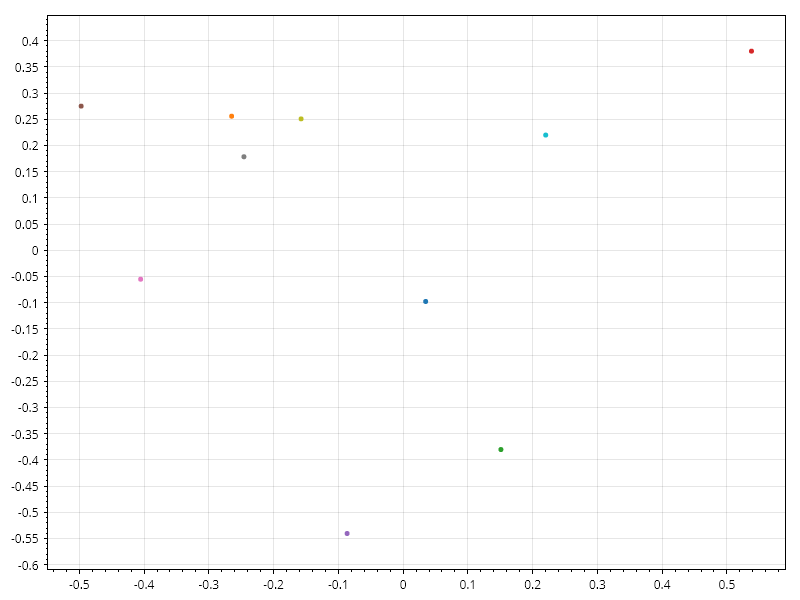

In [25]:
ScottPlot.Plot clusterRepresentativePlot = new();
int i = 0;
foreach (var clusterRepresentative in clusterRepresentatives)
{
    var color = colors.ElementAt(i++ % colors.Length);
    var pc = principalComponents.Single(c => c.PartitionIndex == clusterRepresentative.paritionIndex);
    clusterRepresentativePlot.Add.Scatter(pc.PrincipalComponents[0], pc.PrincipalComponents[1], color: color);
}

clusterRepresentativePlot

## Summarizing

For summarization we use [Anthropic Claude 3.5 Sonnet](https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-claude.html) on Amazon Bedrock.

In [26]:
record SummarizeResponse(string summary, int inputTokens, int outputTokens);

async Task<SummarizeResponse> Summarize(string text, CancellationToken cancellationToken = default)
{
    const string prompt = 
        """
        Provide a summary of the following text. Your result must be detailed and atleast 2 paragraphs.
        When summarizing, directly dive into the narrative or descriptions from the text without using
        introductory phrases like 'In this passage'. Directly address the main events, characters, and
        themes, encapsulating the essence and significant details from the text in a flowing narrative.
        The goal is to present a unified view of the content, continuing the story seamlessly as if the
        passage naturally progresses into the summary.
        """;

    var ask =
        $"""
        {prompt}
        
        Passage:
        {text}
        """;

    var response = await bedrock.ConverseAsync(new ConverseRequest
    {
        ModelId = "anthropic.claude-3-5-sonnet-20240620-v1:0",
        Messages = [new() { Role = ConversationRole.User, Content = [new ContentBlock { Text = ask }] }],
        InferenceConfig = new InferenceConfiguration { Temperature = 0.0F, MaxTokens = 512, },
    }, cancellationToken);

    var responseMessage = string.Concat(response.Output.Message.Content.Select(c => c.Text));

    return new SummarizeResponse(responseMessage, response.Usage.InputTokens, response.Usage.OutputTokens);
}

In [27]:
record PartitionSummary(SummarizeResponse summary, int paritionIndex);

var summarizeStopwatch = Stopwatch.StartNew();
var summaryTasks = clusterRepresentatives
    .Select(async clusterRepresentative =>
    {
        var summary = await Summarize(clusterRepresentative.partition);
        return new PartitionSummary(summary, clusterRepresentative.paritionIndex);
    })
    .ToList();
await Task.WhenAll(summaryTasks);
var summaries = summaryTasks
    .Select(t => t.Result)
    .OrderBy(s => s.paritionIndex)//keeping the order of the original partitions of source document
    .ToList();

var concatenatedSummary = string.Join("\n\n", summaries.Select(s => s.summary.summary));
var totalInputTokens = summaries.Sum(s => s.summary.inputTokens);
var totalOutputTokens = summaries.Sum(s => s.summary.outputTokens);
summarizeStopwatch.Stop();

display($"Summarizing {clusterRepresentatives.Count} cluster representatives took {summarizeStopwatch.Elapsed}, {totalInputTokens} input tokens and {totalOutputTokens} output tokens.");
//display(concatenatedSummary);

Summarizing 10 cluster representatives took 00:00:06.9860637, 8984 input tokens and 2819 output tokens.